# Predicción de Tratamientos químicos de Integridad & Corrosión para pozos productores de petróleo

 
#### <div style="text-align: justify">  El objeto de este cuaderno es presentar un modelo de aplicación de algoritmos de Machine Learning, puntualmente el de Neural Network, para asistir en la predicción de tratamientos de integridad y corrosión para pozos productores de petróleo, a partir de una base de datos de recomendaciones técnicas realizadas por personal de ingeniería. La implementación de esta tecnología permitiría considerar rápidamente antecedentes y la situación global de los yacimientos a la hora de realizar una recomendación, minimizando además el tiempo requerido por las mismas. 
</div>

<div style="text-align: justify"> El concepto general de machine learning es utiizar muestras de datos para escribir programas, sin escribirlos de manera explícita. De esta manera, no se programa cómo se debe realizar la toma de decisiones del tratamiento a emplear, sino que se toma el conjunto de todos los datos de entrada junto con todos los tratamientos recomendados a partir de los mismos y el algoritmo "aprende" el proceso implícito involucrado.

Para el objetivo de este proyecto, se decide implementar una red neuronal que permita hacer una clasificación multivariable devolviendo el set de tratamientos químicos recomendado para las problemáticas del pozo en cuestión.
</div>

Estructura conceptual de una red neuronal:

<img src="files/Artificial-neural-network-architecture.png" style="width: 600px;"/>



<div style="text-align: justify">Importación de los paquetes básicos a utilizar en este cuaderno. Tener en cuenta que los mismos deben estar previamente instalados en el global/virtual environment.

        -NumPy da soporte para crear vectores y matrices multidimensionales, junto con funciones matemáticas de alto nivel para operar con estos elementos.

        -Pandas es una extensión de NumPy para manipulación y análisis de datos. En particular, ofrece estructuras de datos y operaciones para manipular tablas numéricas y series temporales.

        -Matplotlib es una biblioteca para la generación de gráficos a partir de datos contenidos en listas o arrays en Python y NumPy.

        -Seaborn es otra biblioteca para visualización de datos, basada en Matplotlib y centrándose en gráficos estadísticos.
</div>

In [74]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Lectura del archivo excel de base de datos de recomendaciones, a utilizar para entrenar el modelo. 

In [75]:
df=pd.read_excel(os.path.join('Data', 'BD Autom Recomendaciones.xlsx'))
df.head()

,Número de protocolo,Responsable,Operadora,Pozo,Batería,Yacimiento,Base,Fecha de emisión,SLA,Prod Bruta,...,Costo [U$S/mes] TQ Propuesto 2,PQ Propuesto 3,Modalidad PQ Propuesto 3,Punto Inyección PQ Propuesto 3,Tasa Inyección (l/d) PQ Propuesto 3,Volumen Batch PQ Propuesto 3 (l),Frecuencia batcheo PQ Propuesto 3,Concentración [ppmV] PQ Propuesto 3,Precio del PQ [U$S/l] Propuesto 3,Costo [U$S/mes] TQ Propuesto 3
0,0,Ingeniero 1,Operadora 1 Santa Cruz,0,0,El Chola,Las Heras,2020-02-27,BES,60.0,...,324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Ingeniero 2,Operadora 1 Chubut,1,1,El Trébol,Comodoro Rivadavia,2020-10-27,AIB,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Ingeniero 2,Operadora 1 Chubut,2,2,El Trébol,Comodoro Rivadavia,2020-10-27,BES,222.0,...,670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Ingeniero 2,Operadora 1 Chubut,3,3,El Trébol,Comodoro Rivadavia,2020-10-28,AIB,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Ingeniero 2,Operadora 1 Chubut,4,4,El Trébol,Comodoro Rivadavia,2020-10-28,AIB,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df.describe()

,Número de protocolo,Pozo,Batería,Prod Bruta,Prod Neta,Corte de agua (%),SD,OT,CIP,Corrosión según Fe+2,...,Costo [U$S/mes] TQ Propuesto 1,Volumen Batch PQ Propuesto 2 (l),Concentración [ppmV] PQ Propuesto 2,Precio del PQ [U$S/l] Propuesto 2,Costo [U$S/mes] TQ Propuesto 2,Tasa Inyección (l/d) PQ Propuesto 3,Volumen Batch PQ Propuesto 3 (l),Concentración [ppmV] PQ Propuesto 3,Precio del PQ [U$S/l] Propuesto 3,Costo [U$S/mes] TQ Propuesto 3
count,192.000000,192.000000,192.000000,192.000000,192.000000,190.000000,192.000000,192.000000,192.000000,191.000000,...,174.000000,62.000000,39.000000,103.000000,103.000000,6.000000,19.000000,6.000000,25.000000,25.000000
mean,95.500000,95.500000,95.500000,83.870833,3.396635,93.615853,0.953736,1.169923,255.643776,1.498684,...,502.697165,131.241935,75.897436,3.463883,566.190939,6.833333,106.315789,49.333333,3.129200,531.120167
std,55.569776,55.569776,55.569776,68.179070,6.241990,9.939685,0.624112,0.530404,240.446757,2.066938,...,259.810171,59.043103,38.327395,0.492607,224.639305,1.471960,46.092965,2.503331,0.421178,158.790041
min,0.000000,0.000000,0.000000,2.000000,0.080000,18.000000,-0.800000,-0.500000,-727.000000,0.000000,...,102.900000,20.000000,41.000000,2.070000,145.500000,5.000000,40.000000,47.000000,2.070000,207.000000
25%,47.750000,47.750000,47.750000,30.000000,1.142500,95.029412,0.555569,0.869201,114.335459,0.303432,...,343.000000,100.000000,54.500000,3.040000,370.000000,6.000000,100.000000,48.000000,2.910000,439.000000
50%,95.500000,95.500000,95.500000,65.000000,2.180000,96.500000,0.912174,1.200000,256.500000,0.819191,...,432.000000,100.000000,63.000000,3.430000,540.000000,6.500000,100.000000,48.500000,3.040000,568.000000
75%,143.250000,143.250000,143.250000,125.500000,4.185000,97.500000,1.400000,1.500000,363.285932,1.691107,...,686.000000,200.000000,78.000000,3.550000,694.000000,7.750000,100.000000,49.750000,3.430000,582.000000
max,191.000000,191.000000,191.000000,356.000000,82.100000,99.900000,2.519783,2.525622,1096.725139,13.871209,...,1664.000000,200.000000,226.000000,4.440000,1420.000000,9.000000,200.000000,54.000000,4.390000,832.000000


In [77]:
for col in df.columns:
    print(col)

Número de protocolo
Responsable
Operadora
Pozo
Batería
Yacimiento
Base
Fecha de emisión
SLA
Prod Bruta
Prod Neta
Corte de agua (%)
Fecha Control
Objetivo Recomendación
SD
OT
CIP
Corrosión según Fe+2
Corr según CO2 (aq)
Corr según CO2 (g)
Corr según H2S (g)
BSRp
PQ Anterior 1
Modalidad PQ Anterior 1
Punto Inyección PQ Anterior 1
Tasa Inyección (l/d)  PQ Anterior 1 
Volumen Batch PQ Anterior 1 (l)
Frecuencia batcheo PQ Anterior 1
Concentración [ppmV] PQ Anterior 1
Precio del PQ [U$S/l] Anterior 1
Costo [U$S/mes] TQ Anterior 1
PQ Anterior 2
Modalidad PQ Anterior 2
Punto Inyección PQ Anterior 2
Tasa Inyección (l/d)  PQ Anterior 2 
Volumen Batch PQ Anterior 2 (l)
Frecuencia batcheo PQ Anterior 2
Concentración [ppmV] PQ Anterior 2
Precio del PQ [U$S/l] Anterior 2
Costo [U$S/mes] TQ Anterior 2
PQ Propuesto 1
Modalidad PQ Propuesto 1
Punto Inyección PQ Propuesto 1
Tasa Inyección (l/d)  PQ Propuesto 1 
Volumen Batch PQ Propuesto 1 (l)
Frecuencia batcheo PQ Propuesto 1
Concentración [ppmV] PQ Pr

Filtrado de la base de datos para ver sólo las recomendaciones a utilizar. Para entrenar esta Neural Network, se utilizarán solamente las recomendaciones emitidas para la "Operadora 1" de la provincia de Chubut.

In [78]:
df= df[df["Operadora"]=="Operadora 1 Chubut"]
df=df.reset_index()

### Las variables de entrada para la Neural Network serán las siguientes 11:

    SD, OT, CIP, Corr Fe+2, Corr CO2 (aq), Corr H2S (g), Corr CO2 (g), BSRp, Prod Bruta, Prod Neta y SLA

#### Definición de las variables de entrada cualitativas en términos binarios

Se elige definir como 1 cuando el SLA es BES y 0 cuando es AIB o PCP, ya que se implementan tratamientos diferenciales para el primer sistema.

In [79]:
for i in range(len(df['Número de protocolo'])):
    if 'BES' in str(df['SLA'][i]):
        df['SLA'][i]=1
    else:
        df['SLA'][i]=0

var_cual=df['SLA']
var_cual

0      0
1      1
2      0
3      0
4      1
      ..
177    0
178    1
179    1
180    0
181    0
Name: SLA, Length: 182, dtype: object

#### Escalar variables de entrada cuantitativas

Se escalan los parámetros de entrada a la neural network en rangos entre 0 y 1. Esto se realiza a fin de agilizar el cálculo y mejorar la precisión de la misma. 

El escalador utilizado en el presente proyecto está dado por:

        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

        X_scaled = X_std * (max - min) + min

        where min, max = feature_range.

Como se puede ver en los gráficos debajo, las variables cuantitativas utilizadas se encuentran en rangos amplios y diferentes entre sí. Esto se soluciona con el escalado.

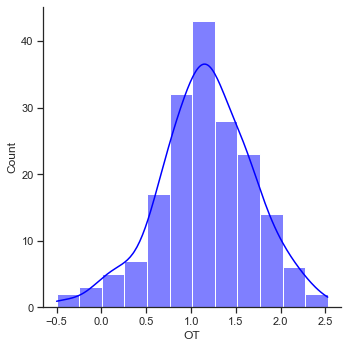

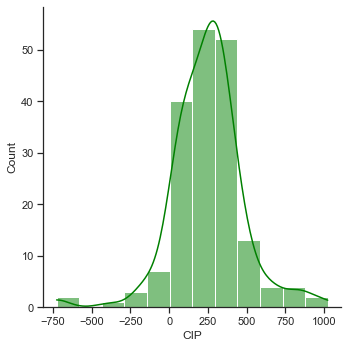

In [80]:
sns.displot(df['OT'], kind='hist', kde=True, bins=int(6/0.5), color = 'blue')
sns.displot(df['CIP'], kind='hist', kde=True, bins=int(6/0.5), color = 'green')

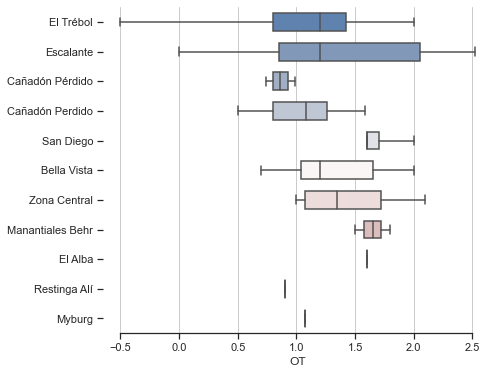

In [81]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("linear")
sns.boxplot(x="OT", y="Yacimiento", data=df,
            whis=[0, 100], width=.6, palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

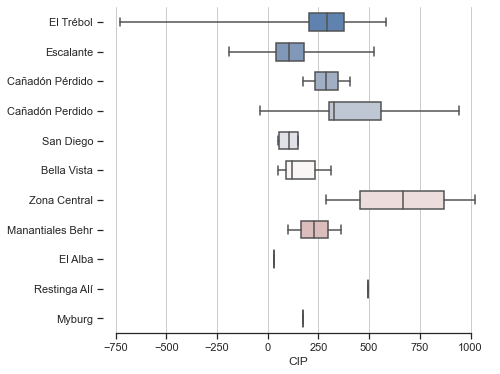

In [82]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("linear")
sns.boxplot(x="CIP", y="Yacimiento", data=df,
            whis=[0, 100], width=.6, palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [83]:
import sklearn as skl
from sklearn.preprocessing import MinMaxScaler

In [84]:
scaler=MinMaxScaler()

In [85]:
var_cuant=df[['SD','OT','CIP','Corr según H2S (g)','BSRp','Corrosión según Fe+2','Prod Bruta','Prod Neta','Corr según CO2 (aq)','Corr según CO2 (g)']]

Además de escalar las variables cuantitativas, se llenan los datos vacíos con la media de la respectiva variable escalada.

In [86]:
var_cuant[['SD','OT','CIP','Corr según H2S (g)','BSRp','Corrosión según Fe+2','Prod Bruta','Prod Neta','Corr según CO2 (aq)','Corr según CO2 (g)']]=scaler.fit_transform(var_cuant)

var_cuant.fillna(var_cuant.mean(), inplace=True)

var_cuant.head()

,SD,OT,CIP,Corr según H2S (g),BSRp,Corrosión según Fe+2,Prod Bruta,Prod Neta,Corr según CO2 (aq),Corr según CO2 (g)
0,0.572327,0.594919,0.582524,0.141212,0.000000,0.027395,0.079096,0.005365,0.194619,0.003883
1,0.632571,0.561868,0.629355,0.070606,0.625000,0.250158,0.621469,0.039624,0.809709,0.004854
2,0.632571,0.694072,0.629355,0.000000,0.125000,0.134812,0.059322,0.013046,0.265579,0.029773
3,0.210857,0.231357,0.384923,0.000000,0.250000,0.340994,0.070621,0.012192,0.080184,0.003560
4,0.930673,0.916474,0.480552,0.315261,0.329392,0.058022,0.522599,0.022860,0.187280,0.028907


Se verifica el escalado graficando la CIP para cada yacimiento. Notar que la distribución relativa de los datos es la misma, encontrándose todos en un rango entre 0 y 1.

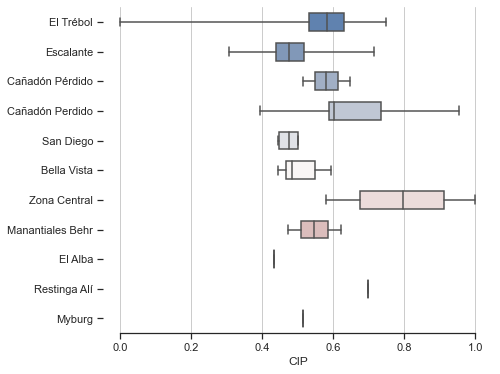

In [87]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("linear")
sns.boxplot(x="CIP", y=df["Yacimiento"], data=var_cuant,
            whis=[0, 100], width=.6, palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

Se unen las variables cualitativas con cuantitativas en un único dataframe de variables de entrada.

In [88]:
var_input=var_cuant.join(var_cual)
var_input.head()

,SD,OT,CIP,Corr según H2S (g),BSRp,Corrosión según Fe+2,Prod Bruta,Prod Neta,Corr según CO2 (aq),Corr según CO2 (g),SLA
0,0.572327,0.594919,0.582524,0.141212,0.000000,0.027395,0.079096,0.005365,0.194619,0.003883,0
1,0.632571,0.561868,0.629355,0.070606,0.625000,0.250158,0.621469,0.039624,0.809709,0.004854,1
2,0.632571,0.694072,0.629355,0.000000,0.125000,0.134812,0.059322,0.013046,0.265579,0.029773,0
3,0.210857,0.231357,0.384923,0.000000,0.250000,0.340994,0.070621,0.012192,0.080184,0.003560,0
4,0.930673,0.916474,0.480552,0.315261,0.329392,0.058022,0.522599,0.022860,0.187280,0.028907,1


### Las variables de salida para la Neural Network serán las siguientes 6, representando cada tipo de Tratamiento de I&C:

                DS   = Tratamiento desincrustante batch
                IC = Tratamiento inhibidor de incrustaciones continuo
                CY.C = Tratamiento inhibidor de corrosión continuo  
                CY.B = Tratamiento inhibidor de corrosión batch
                BX.C = Tratamiento bactericida continuo
                BX.B = Tratamiento bactericida batch

#### Definición de las variables de salida en términos binarios

Se crea un dataframe de output con columnas conteniendo 1 o 0 en cada fila en función de haberse o no recomendado determinado tratamiento.

In [89]:
output=['DS', 'IC','CY.C', 'CY.B', 'BX.C','BX.B']

var_output=pd.DataFrame(np.zeros((len(df['Número de protocolo']),len(output))), columns=output)

In [90]:
DI=['DS','IC']
num=[1,2,3]

for j in DI:
    for n in num:
        for i in range(len(var_output[j])): 
            if j in str(df[f'PQ Propuesto {n}'][i]):
                var_output[j][i]=1
            else: 
                None

In [105]:
CB=['CY', 'BX']

for n in num:
    for PQ in CB:    
        for i in range(len(var_output['DS'])): 
            if PQ in str(df[f'PQ Propuesto {n}'][i]):
                if 'Batch' in str(df[f'Modalidad PQ Propuesto {n}'][i]): 
                    var_output[PQ+'.B'][i]=1
                else:
                    var_output[PQ+'.C'][i]=1

var_output

,DS,IC,CY.C,CY.B,BX.C,BX.B
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
177,0.0,1.0,0.0,0.0,0.0,0.0
178,0.0,1.0,0.0,1.0,0.0,0.0
179,0.0,0.0,0.0,1.0,0.0,1.0
180,0.0,0.0,0.0,1.0,0.0,0.0


Se utiliza la librería scikit-learn para realizar un split sobre el dataset a fin de luego testear la precisión del modelo. Se decida emplear un 80% de los datos para entrenar la red neuronal y el 20% restante para el validation test. Los datos son segmentados de manera aleatoria.

In [92]:
from sklearn.model_selection import train_test_split

In [93]:
var_input=np.asarray(var_input).astype('float32')
X=var_input
y=var_output

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

Para definir y entrenar el modelo se utiliza la plataforma TensorFlow, que soporta la librería Keras, conteniendo los algoritmos necesarios para implementar redes neuronales.

In [95]:
import tensorflow as tf
from tensorflow import keras

Se importan de Keras los módulos Dense, Dropout y Sequential:

        -La técnica Dropout se utiliza para minimizar el over-fitting y consite en reducir de manera aleatoria el número de neuronas interconectadas dentro de una red neuronal. A cada iteración del entrenamiento, cada neurona tiene una probabilidad de que su contribución sea considerada o no para las neuronas conectadas. 

        -Dense conecta cada una de las neuronas de una capa con todas las neuronas de la capa siguiente. 

        -Sequential es el modelo empleado para determinar los parámetros que conformarán el modelo. Este en particular es apropiado para una estructura simple de capas donde cada capa tiene exactamente un tensor de entrada y un tensor de salida .

In [96]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

<div style="text-align: justify">
Se diseña una red neuronal que consta de una input layer de 11 nodos, 4 hidden layers de 16 nodos cada una y una output layer de 6 nodos.

Se interconectan las mismas de una manera Densa y se aplica el método Dropout, a excepción de la última capa, para no desactivar salidas.

Para la input layer y las hidden layers se utilizan funciones de activación ReLU (Rectified Linear Unit) tipo rampa. Comparada con funciones sigmoides, esta permite entrenamientos más rápidos y efectivos para sistemas complejos.

Respecto a la output layer, se elige una sigmoide como función de activación, a fin de lograr salidas que se encuentren en el rango entre 0 y 1.
</div>


<img src="files/activation.png" style="width: 500px"/>


<div style="text-align: justify">
Para compilar el modelo, se requiere definir una función de error o pérdida (loss) junto con un optimizador. El objetivo de las loss functions es calcular el parámetro que el modelo debería tender a minimizar durante el entrenamiento. Por su parte, el optimizador persigue mejorar la variable monitoreada en cada iteración realizada.
 Para este proyecto se utiliza una función Binary Crossentropy para el cálculo del error y el optimizador Adam.
</div>

In [97]:
model=keras.Sequential()

model.add(Dense(11,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam')

Se establece un Early Stopping que detenga el entrenamiento cuando un determinado parámetro monitoreado deja de mejorar. Para este proyecto, se define un early stopping que siga la validation loss (error entre la variable de output predicha por el modelo y la variable output correcta en el grupo de testeo) y que detendrá el algoritmo cuando dicho error no mejore de manera significativa durante 50 iteraciones.



In [98]:
from tensorflow.keras.callbacks import EarlyStopping

In [99]:
es=EarlyStopping(monitor='val_loss', patience=50, mode='min')

Se inicia el entrenamiento del modelo con 1000 iteraciones, pudiendo ser interrumpidas previamente por el early stopping.

In [100]:
model.fit(X_train,y_train,epochs=1000,validation_data=(X_test,y_test), callbacks=es);

h 135/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.4242 - val_loss: 0.4322
Epoch 136/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.4012 - val_loss: 0.4323
Epoch 137/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.4017 - val_loss: 0.4314
Epoch 138/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.4014 - val_loss: 0.4307
Epoch 139/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.4095 - val_loss: 0.4303
Epoch 140/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.4094 - val_loss: 0.4298
Epoch 141/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.4081 - val_loss: 0.4295
Epoch 142/1000
5/5 [==============================] - 0s 6ms/step - loss: 0.3945 - val_loss: 0.4292
Epoch 143/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.4068 - val_loss: 0.4293
Epoch 144/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.4005 - val_loss: 0.4298
Epo

Se grafican los errores (y predicha - y real) obtenidos tanto con el grupo test como con el set de entrenamiento.

<AxesSubplot:>

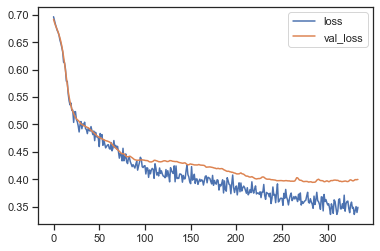

In [101]:
loss=pd.DataFrame(model.history.history)
loss.plot()

Al 20/6/2021, los errores mínimos se obtuvieron con 4 hidden layers de 16 neuronas cada una. Min loss=0.33; Min val_loss=0.42 


Se genera un reporte estadístico acerca de la performance obtenida con el modelo.

In [102]:
from sklearn.metrics import classification_report

In [103]:
predictions=pd.DataFrame(model.predict(X_test),columns=y_test.columns)
predictions=predictions.round(decimals=0)

Al 20/6/2021, se obtuvieron los siguientes parámetros de exactitud para cada tratamiento:

                DS=0.95
                IC=0.89
                CY.C=0.73
                CY.B=0.76
                BX.C=1.00
                BX.B=0.76

In [104]:
for i in range(6):
    print(y_test.columns[i])
    print(classification_report(y_test.iloc[:,i],predictions.iloc[:,i]))
    print(' ')

DS
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        35
         1.0       0.00      0.00      0.00         2

    accuracy                           0.95        37
   macro avg       0.47      0.50      0.49        37
weighted avg       0.89      0.95      0.92        37

 
IC
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87        28
         1.0       0.60      0.67      0.63         9

    accuracy                           0.81        37
   macro avg       0.74      0.76      0.75        37
weighted avg       0.82      0.81      0.81        37

 
CY.C
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84        27
         1.0       0.00      0.00      0.00        10

    accuracy                           0.73        37
   macro avg       0.36      0.50      0.42        37
weighted avg       0.53      0.73      0.62        37

 
CY